In [7]:
#coding=utf-8
import numpy as np
import pandas as pd
import random
import time
import json
import sys
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, roc_auc_score
from collections import Counter
from sklearn.model_selection import GroupKFold
import xgboost
import lightgbm as lgb

data_path = r'D:\kaggle\data\tianchi_disk\a'[: -1]

def read_data_csv(data_name, mark = -1):
    if mark < 0:
        df = pd.read_csv(data_path + data_name + '.csv')
    else:
        df = pd.read_csv(data_path + data_name + '.csv', nrows = mark)
    return df

def read_data(read_rows):
    data_pre_name = 'disk_sample_smart_log_'
    df = read_data_csv(data_pre_name + '201707' + '_sample_pn_v2', read_rows)
    print '201707', df.shape
    for day in range(201708, 201713) + range(201801, 201808):
        df_temp = read_data_csv(data_pre_name + str(day) + '_sample_pn_v2', read_rows)
        df = pd.concat([df, df_temp])
        print day, df.shape
    df_test = read_data_csv('disk_sample_smart_log_test_a', -1)
    return df, df_test

In [12]:
def get_weight_label(df_train, df_test):
    print '\nget_weight_label', '-' * 100
    print 'dt, fault_time isna : ', df_train['dt'].isna().sum(), df_train['fault_time'].isna().sum()
    # print df_train[['dt', 'fault_time']].head(100)
    df_train['dt'] = df_train['dt'].fillna('19970102')
    df_train['dt'] = df_train['dt'].apply(lambda x: time.strftime('%Y-%m-%d', time.strptime(str(x), '%Y%m%d')))
    df_train['fault_time'] = df_train['fault_time'].fillna('1997-01-02')
    df_train['dt_day'] = df_train['dt'].apply(lambda x: int(time.mktime(time.strptime(str(x), "%Y-%m-%d")) / 24 / 3600))
    df_train['broken_day'] = df_train['fault_time'].apply(lambda x: int(time.mktime(time.strptime(x, "%Y-%m-%d")) / 24 / 3600))
    df_train['dis_day'] = (df_train['broken_day'] - df_train['dt_day']).apply(lambda x: -1 if x < 0 else -1 if x >= 30 else x)
    # print df_train[df_train['dt'] == 20170709][['dt', 'fault_time', 'broken_day', 'dt_day', 'dis_day']].head(10)
    df_train['label'] = df_train['dis_day'].apply(lambda x: 1 if x != -1 else 0)
    weight = df_train['dis_day'].apply(lambda x: 1 if x == -1 else 30 - x)
    label = df_train['label']
    # write_data_csv('df_train', df_train)
    # write_data_csv('df_test', df_test)
    return df_train, df_test, weight, label

In [9]:
df_train, df_test = read_data(-1)


201707 (129701, 516)
201708 (372119, 516)
201709 (595045, 516)
201710 (826694, 516)
201711 (1044560, 516)
201712 (1282160, 516)
201801 (1521179, 516)
201802 (1705737, 516)
201803 (1877623, 516)
201804 (2013209, 516)
201805 (2120657, 516)
201806 (2192399, 516)
201807 (2221725, 516)

get_weight_label ----------------------------------------------------------------------------------------------------
dt, fault_time isna :  0 2019750


ValueError: time data '20170722' does not match format '%Y-%m-%d'

In [13]:
df_train, df_test, weight, label = get_weight_label(df_train, df_test)


get_weight_label ----------------------------------------------------------------------------------------------------
dt, fault_time isna :  0 0


In [16]:
ratio = df_train.isna().sum() / len(df_train)
print type(ratio)
print len(ratio)

<class 'pandas.core.series.Series'>
520


In [21]:
cols = ratio[ratio < 0.2].index.tolist()
print len(cols)
features = []
for col in cols:
    if col[-3: ] == 'raw':
        features.append(col)
print features, len(features)

52
['smart_1raw', 'smart_3raw', 'smart_4raw', 'smart_5raw', 'smart_7raw', 'smart_9raw', 'smart_10raw', 'smart_12raw', 'smart_184raw', 'smart_187raw', 'smart_188raw', 'smart_189raw', 'smart_190raw', 'smart_191raw', 'smart_192raw', 'smart_193raw', 'smart_194raw', 'smart_195raw', 'smart_197raw', 'smart_198raw', 'smart_199raw'] 21


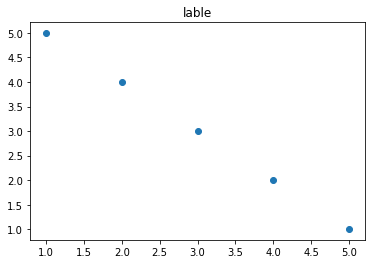

In [23]:
plt.scatter([5,4,3,2,1], [1,2,3,4,5])
plt.title('lable')
plt.show()

C:\file\anaconda2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


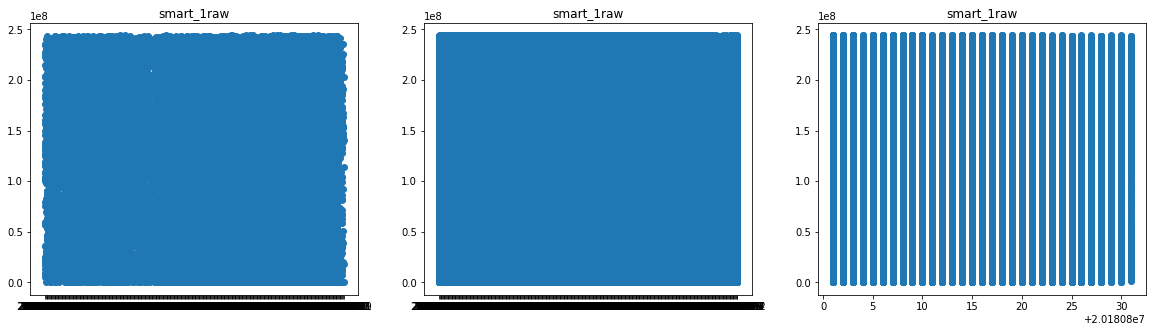

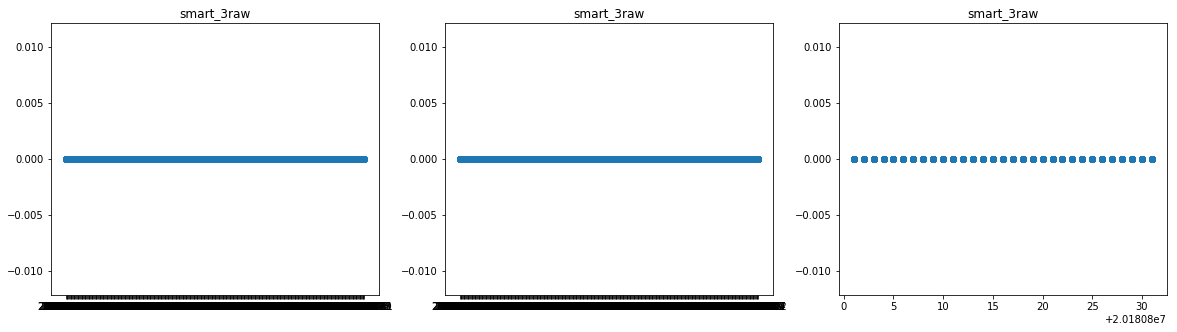

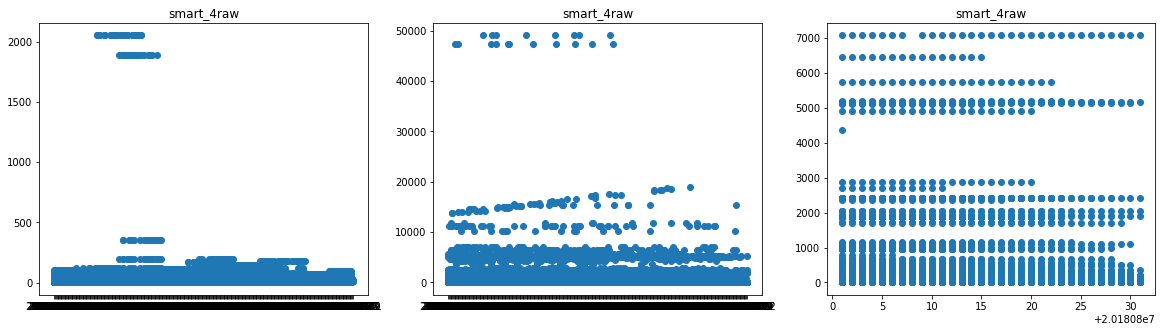

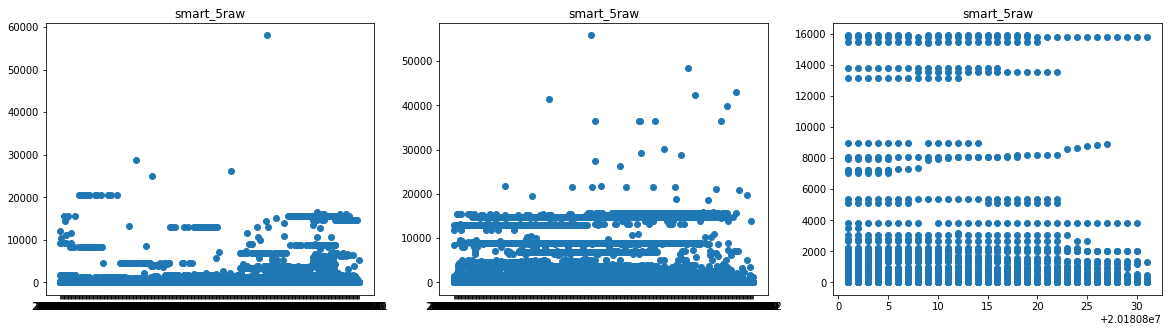

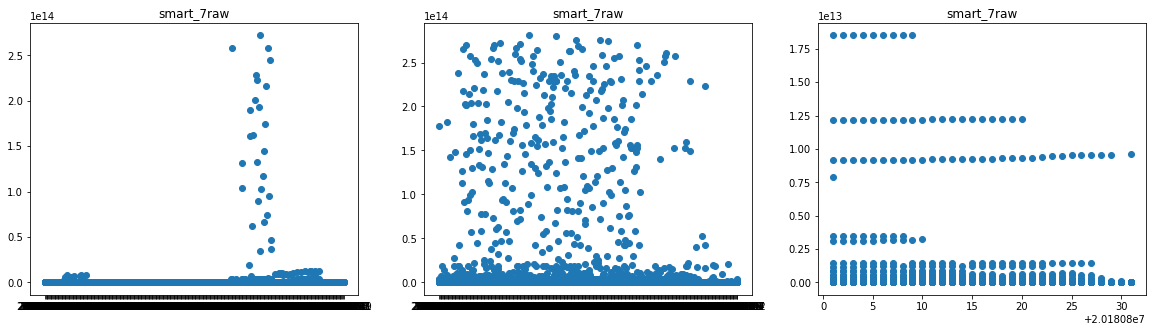

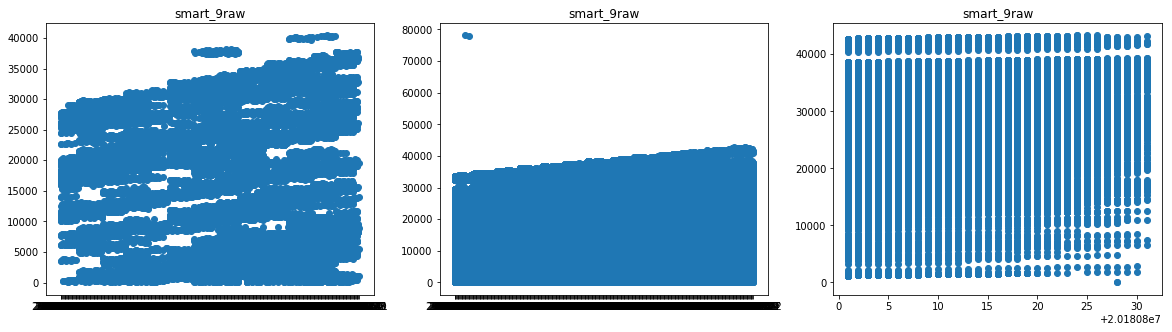

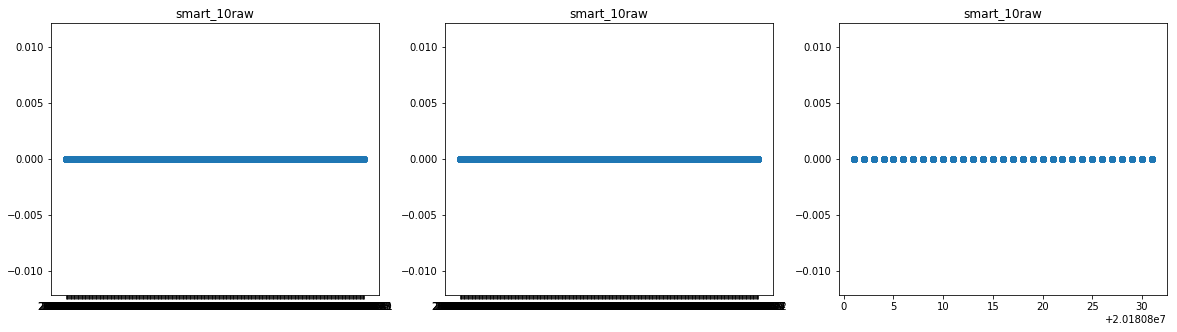

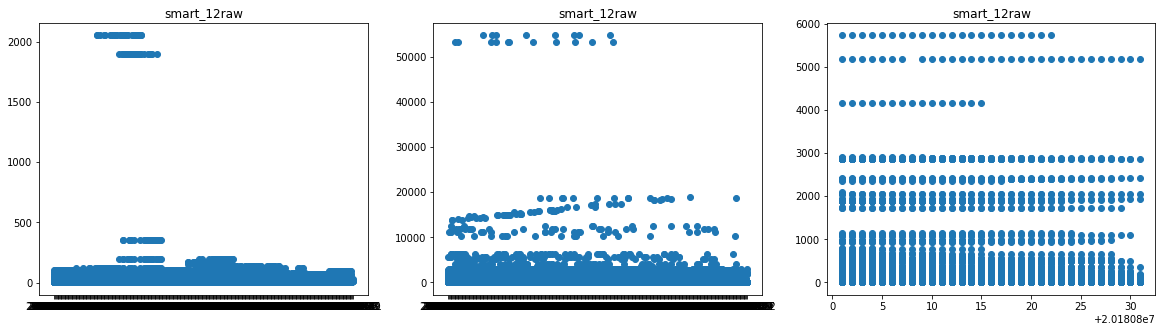

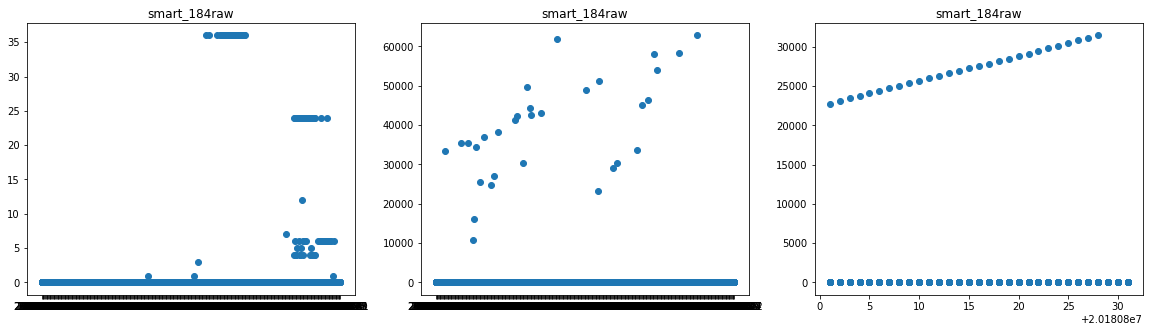

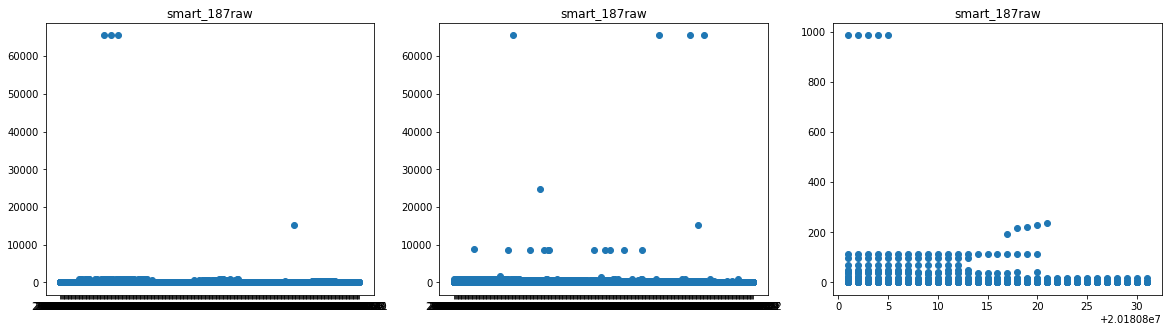

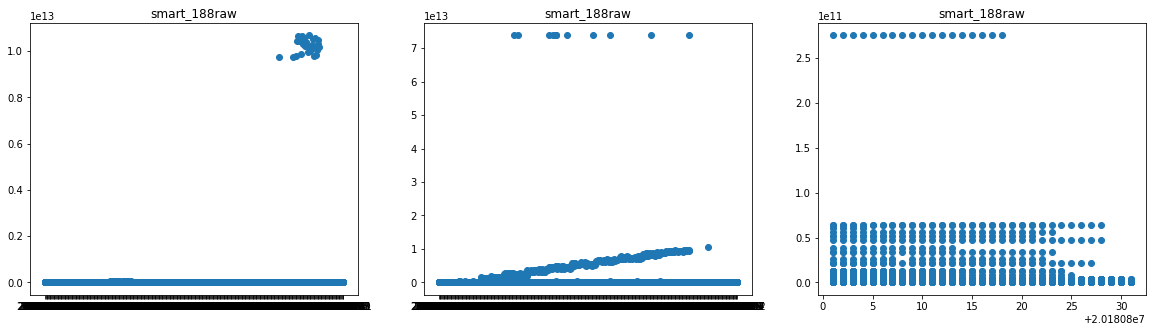

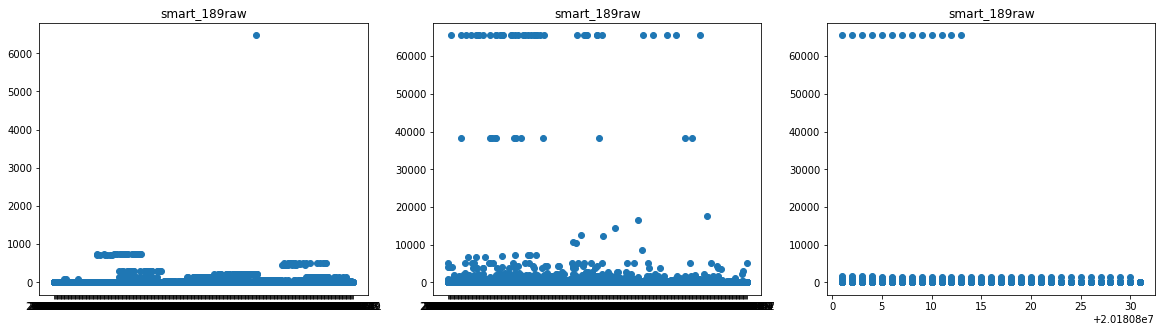

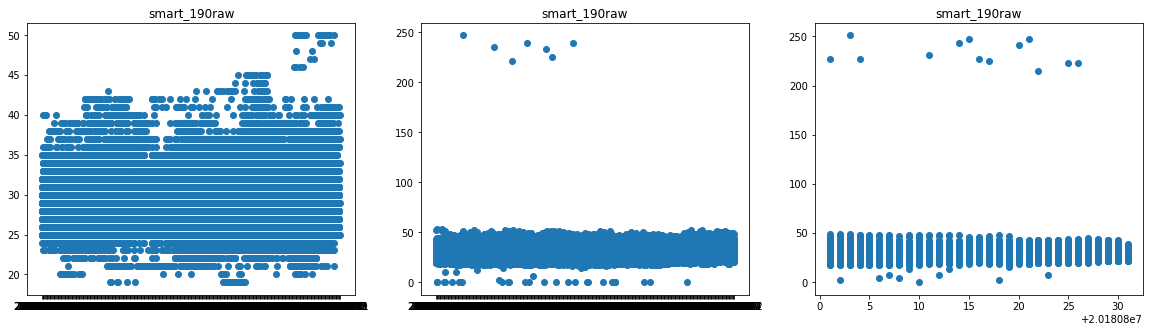

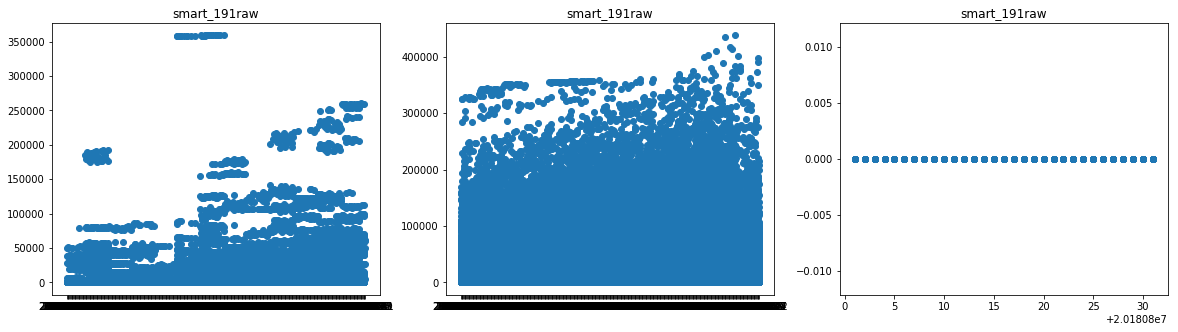

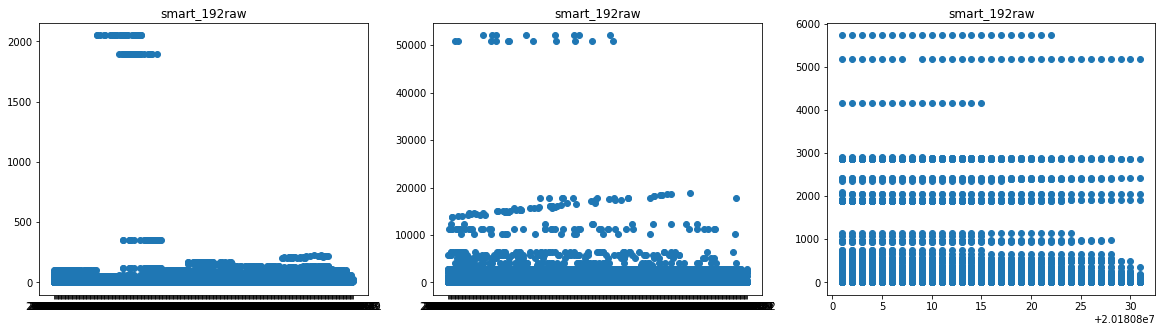

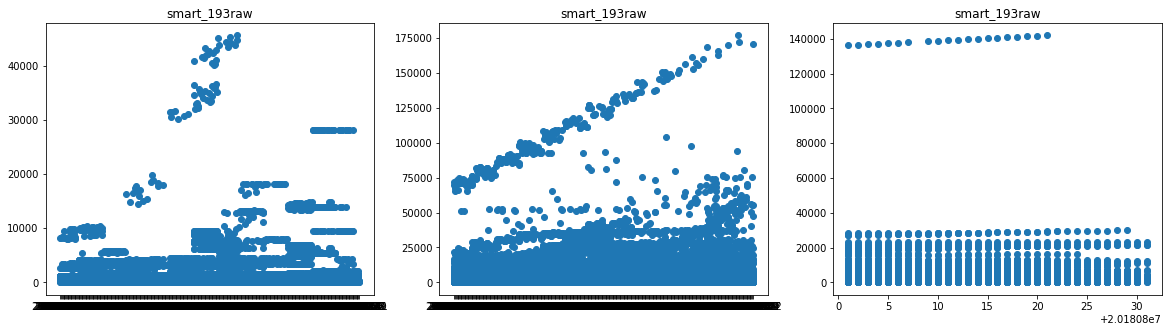

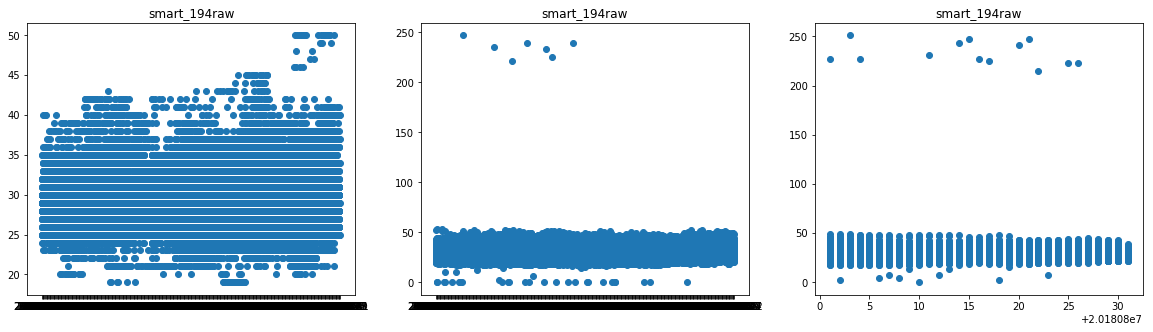

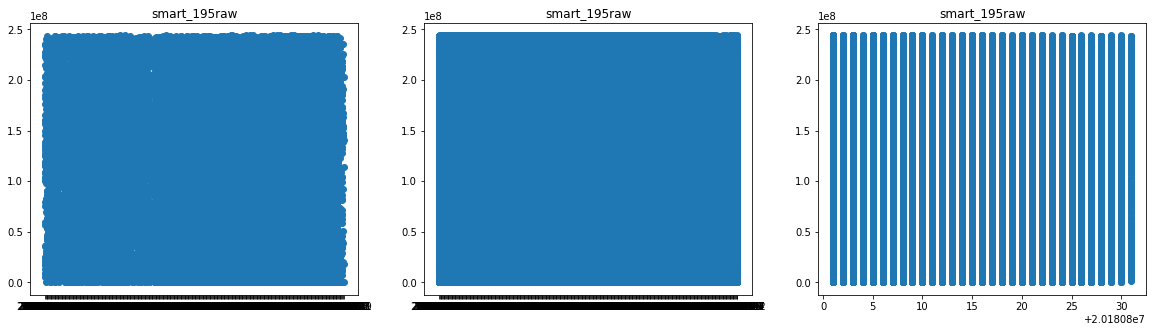

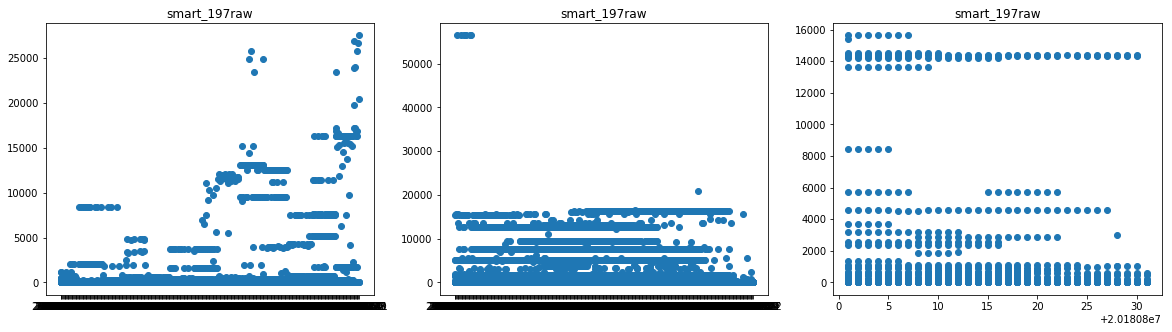

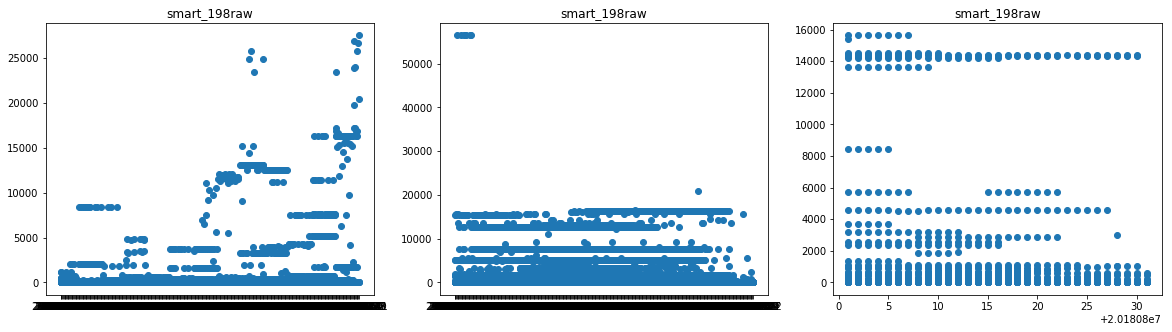

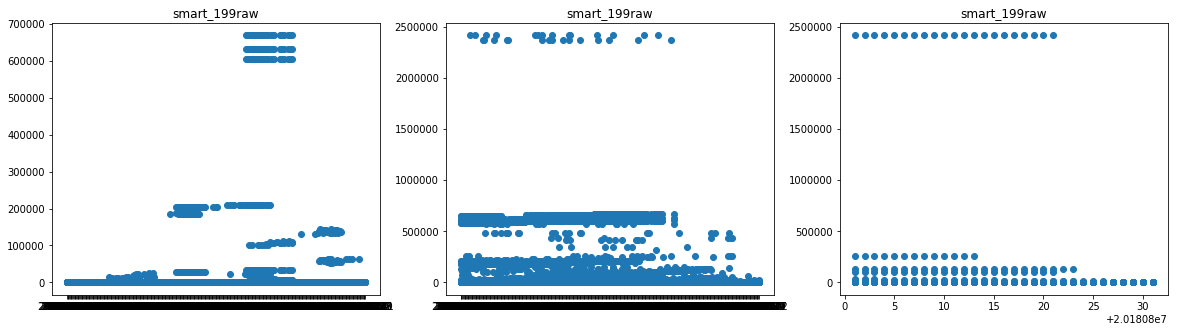

In [26]:
col_index = 0
for col_index in range(len(features)):
    plt.figure(figsize = (20, 5))
    
    plt.subplot(1, 3, 1) # row行，col列的大图上，绘制第i个图
    plt.scatter(df_train[df_train['label'] == 1]['dt'], df_train[df_train['label'] == 1][features[col_index]].astype(np.float))
    plt.title(features[col_index])
    
    plt.subplot(1, 3, 2) # row行，col列的大图上，绘制第i个图
    plt.scatter(df_train[df_train['label'] == 0]['dt'], df_train[df_train['label'] == 0][features[col_index]].astype(np.float))
    plt.title(features[col_index])
    
    plt.subplot(1, 3, 3) # row行，col列的大图上，绘制第i个图
    plt.scatter(df_test['dt'], df_test[features[col_index]].astype(np.float))
    plt.title(features[col_index])

plt.show()